## Imports

In [1]:
import os
import numpy as np
import warnings
import torch
import torchvision
import matplotlib.pyplot as plt

%matplotlib inline

## Dataloaders

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


def get_data_loader(image_type, image_dir='celeba', 
                    image_size=64, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
#     test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(train_path, transform)
#     test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data

image_size = 128
batch_size = 16
num_workers = 8

dataloader_X, test_dataloader_X = get_data_loader(image_type='no-makeup', image_size=image_size,
                                                  batch_size=batch_size, num_workers=num_workers)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='makeup', image_size=image_size,
                                                  batch_size=batch_size, num_workers=num_workers)

## Dataset

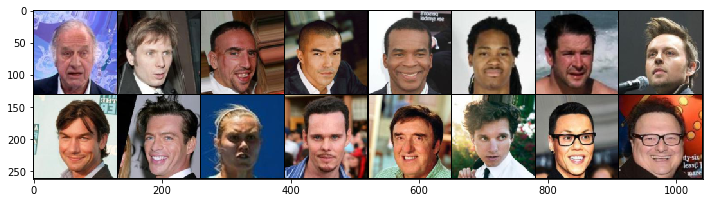

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images[:16]))

Next, let's visualize a batch of images from set $Y$.

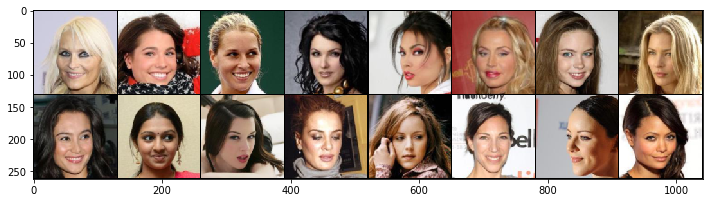

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images[:16]))

## Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0118)
Max:  tensor(0.9961)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9765)
Scaled max:  tensor(0.9922)


## Models

### Helper functions

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [10]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim,
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim,
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        
        return out_2
    

### Networks

In [12]:
class Discriminator(nn.Module):
    
    def __init__(self, n_input_images=1, conv_dim=64):
        super(Discriminator, self).__init__()

        self.conv1 = conv(3*n_input_images, conv_dim, 4, batch_norm=False) # (64, 64, conv_dim)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)                         # (32, 32, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)                       # (16, 16, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)                       # ( 8,  8, conv_dim*8)
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)    # 1 or 0

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.conv5(out)
        
        return out

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, n_input_images=1, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()
        
        self.n_input_images = n_input_images

        self.conv1 = conv(3*n_input_images, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*res_layers)

        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):        
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = torch.tanh(self.deconv3(out)) # tanh
        
        if self.n_input_images == 2:
            split = torch.split(x, 3, dim=1)
            x = split[0]
            result = x + out # TODO apply poisson blending
            result[result > 1] = 1
            result[result < 0] = 0
            
            return result
        else:
            return out

In [14]:
D_X_conv_dim = 32
D_Y_conv_dim = 32
D_S_conv_dim = 32

G_conv_dim = 32
F_conv_dim = 32
G_n_res_blocks = 3
F_n_res_blocks = 3

D_X = Discriminator(conv_dim = D_X_conv_dim)
D_Y = Discriminator(conv_dim = D_Y_conv_dim)
D_S = Discriminator(conv_dim = D_S_conv_dim, n_input_images=2)

G_generator = CycleGenerator(conv_dim = G_conv_dim, n_res_blocks = G_n_res_blocks, n_input_images=2)
F_generator = CycleGenerator(conv_dim = F_conv_dim, n_res_blocks = F_n_res_blocks)

# F_generator.load_state_dict(torch.load("checkpoints_cyclegan/G_YtoX_8000.pkl", map_location='cpu'))

# move models to GPU, if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    D_X.to(device)
    D_Y.to(device)
    D_S.to(device)
    G_generator.to(device)
    F_generator.to(device)
    print('Models moved to GPU.')
else:
    print('Only CPU available.') 

Only CPU available.


In [15]:
def real_mse_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    return lambda_weight * torch.mean(torch.abs(real_im - reconstructed_im))

In [16]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 # default value

GF_optimizer = optim.Adam(
    list(G_generator.parameters()) + list(F_generator.parameters()),
    lr, [beta1, beta2])
D_X_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
D_Y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])
D_S_optimizer = optim.Adam(D_S.parameters(), lr, [beta1, beta2])

In [17]:
G_lambda_weight = 0.1
F_lambda_weight = 0.1
P_lambda_weight = 0.1

## Train

In [18]:
import cv2
import numpy as np
import dlib

from multiprocessing import cpu_count
from multiprocessing import Pool


def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    return x


def scale_back(x):
    x = (x + 1) / 2 * 255
    return x


def chunk(images_Y, images_X, imgsPerProc):
    for i in range(0, images.size(0), imgsPerProc):
        yield images_Y[i:i+imgsPerProc], images_X[i:i+imgsPerProc], imgsPerProc


def swap_faces(images_Y, images_X, batch_size):
    imgs_Y = images_Y
    idxs = torch.arange(imgs_Y.size(0))
    results = torch.tensor([])
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    imgs1 = images_Y.permute(0, 2, 3, 1)
    imgs2 = images_X.permute(0, 2, 3, 1)
    for i in range(batch_size):
        img1 = np.array(imgs1[i])
        img2 = np.array(imgs2[i])

        img1 = scale_back(img1).astype('uint8')
        img2 = scale_back(img2).astype('uint8')
        
#         img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
#         img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        img2_new_face = np.zeros_like(img2, np.uint8)

        face_detector = dlib.get_frontal_face_detector()
        face_landmarks_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        faces = face_detector(img1_gray)
        faces2 = face_detector(img2_gray)

        if len(faces) == 0 or len(faces2) == 0:
            print('No faces detected')
            idxs = idxs[idxs!=i]
            continue
#             raise Exception('No faces detected')

        # Get face landmarks of first image
        for face in faces:
            landmarks = face_landmarks_predictor(img1_gray, face)
            landmarks_points = []
            for n in range(0, 68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                landmarks_points.append((x, y))

            # Build convexhull given the face landmarks
            points = np.array(landmarks_points, np.int32)
            convexhull = cv2.convexHull(points)

            # Delaunay triangulation
            rect = cv2.boundingRect(convexhull)
            subdiv = cv2.Subdiv2D(rect)
            subdiv.insert(landmarks_points)
            triangles = subdiv.getTriangleList()
            triangles = np.array(triangles, dtype=np.int32)

            triangles_indexes = []
            for t in triangles:
                pt1, pt2, pt3 = (t[0], t[1]), (t[2], t[3]), (t[4], t[5])
                index_pt1 = np.where((points == pt1).all(axis=1))[0][0]
                index_pt2 = np.where((points == pt2).all(axis=1))[0][0]
                index_pt3 = np.where((points == pt3).all(axis=1))[0][0]
                if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
                    triangle = [index_pt1, index_pt2, index_pt3]
                    triangles_indexes.append(triangle)

        # Get face landmarks of second image
        for face in faces2:
            landmarks2 = face_landmarks_predictor(img2_gray, face)
            landmarks_points2 = []
            for n in range(0, 68):
                x = landmarks2.part(n).x
                y = landmarks2.part(n).y
                landmarks_points2.append((x, y))

            points2 = np.array(landmarks_points2, np.int32)
            convexhull2 = cv2.convexHull(points2)
            
        try:
            for triangle_index in triangles_indexes:
                # Triangulation of the first face
                tr1_pt1 = landmarks_points[triangle_index[0]]
                tr1_pt2 = landmarks_points[triangle_index[1]]
                tr1_pt3 = landmarks_points[triangle_index[2]]
                triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)
                (x, y, w, h) = cv2.boundingRect(triangle1)
                cropped_triangle = img1[y: y + h, x: x + w]
                cropped_tr1_mask = np.zeros((h, w), np.uint8)
                points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                                   [tr1_pt2[0] - x, tr1_pt2[1] - y],
                                   [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
                cv2.fillConvexPoly(cropped_tr1_mask, points, 255)
                cropped_triangle = cv2.bitwise_and(cropped_triangle, cropped_triangle,
                                                   mask=cropped_tr1_mask)

                # Triangulation of second face
                tr2_pt1 = landmarks_points2[triangle_index[0]]
                tr2_pt2 = landmarks_points2[triangle_index[1]]
                tr2_pt3 = landmarks_points2[triangle_index[2]]
                triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)
                (x, y, w, h) = cv2.boundingRect(triangle2)
                cropped_triangle2 = img2[y: y + h, x: x + w]
                cropped_tr2_mask = np.zeros((h, w), np.uint8)
                points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                                    [tr2_pt2[0] - x, tr2_pt2[1] - y],
                                    [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)
                cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)
                cropped_triangle2 = cv2.bitwise_and(cropped_triangle2, cropped_triangle2,
                                                   mask=cropped_tr2_mask)

                # Warp triangles
                points = np.float32(points)
                points2 = np.float32(points2)
                M = cv2.getAffineTransform(points, points2)
                warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
                warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

                # Reconstructing destination face
                img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
                img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
                _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 0, 255, cv2.THRESH_BINARY_INV)
                warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)
                img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
                img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

            # Face swapped (putting 1st face into 2nd face)
            img2_face_mask = np.zeros_like(img2_gray)
            img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
            img2_face_mask = cv2.bitwise_not(img2_head_mask)

            img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
            result = cv2.add(img2_head_noface, img2_new_face)
            result = torch.from_numpy(result).float()
            result = result.view(1, result.size(0), result.size(1), result.size(2))
            result = scale(result).permute(0, 3, 1, 2)
            results = torch.cat((results, result))#.to(device)
        except:
            idxs = idxs[idxs!=i]
            continue

    return imgs_Y[idxs], results


def dechunk(result):
    imgs_Y, synthetic_Y = torch.tensor([]), torch.tensor([])
    for a, b in result:
        imgs_Y, synthetic_Y = torch.cat((imgs_Y, a)), torch.cat((synthetic_Y, b))
    return imgs_Y, synthetic_Y


def multiprocess_swap_faces(images_Y, images_X, batch_size, num_workers=0):
    procs = num_workers if num_workers > 0 and num_workers < cpu_count() else cpu_count()
    imgsPerProc = int(np.ceil(len(images_X) / float(procs)))
    
    payloads = list(chunk(images_Y, images_X, imgsPerProc))
    
    pool = Pool(processes=procs)
    result = pool.starmap(swap_faces, payloads)
    imgs_Y, synthetic_Y = dechunk(result)
    pool.close()
    pool.join()
    
    return imgs_Y, synthetic_Y
    

In [19]:
#from face_swapper import multiprocess_swap_faces
from helpers import merge_images

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X)
    fixed_Y = scale(fixed_Y)

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X)
        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)
        
        XY_concat = torch.cat((images_X, images_Y), axis=1)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        # D_X
        D_X_optimizer.zero_grad()

        out_X = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_X)

        fake_X = F_generator(images_Y)
        out_X = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_X)

        D_X_loss = D_X_real_loss + D_X_fake_loss
        D_X_loss.backward()
        D_X_optimizer.step()

        
        # D_Y
        D_Y_optimizer.zero_grad()
        
        out_Y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_Y)
        
        fake_Y = G_generator(XY_concat)
        out_Y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_Y)

        D_Y_loss = D_Y_real_loss + D_Y_fake_loss
        D_Y_loss.backward()
        D_Y_optimizer.step()

        # D_S
        D_S_optimizer.zero_grad()
        
        imgs_Y, synthetic_Y = multiprocess_swap_faces(images_Y, images_X, batch_size)
        same_makeup = torch.cat((imgs_Y, synthetic_Y), axis=1)
        out_S = D_S(same_makeup)
        D_S_real_loss = real_mse_loss(out_S)
        
        fake_Y = G_generator(XY_concat)
        not_same_makeup = torch.cat((images_Y, fake_Y), axis=1)
        out_S = D_S(not_same_makeup)
        D_S_fake_loss = fake_mse_loss(out_S)

        D_S_loss = D_S_real_loss + D_S_fake_loss
        D_S_loss.backward()
        D_S_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        # D_Y + X -> Y -> X (Adversarial loss and identity loss)
        GF_optimizer.zero_grad()

        fake_Y = G_generator(XY_concat)

        out_Y = D_Y(fake_Y)
        G_loss = real_mse_loss(out_Y) # L_G

        reconstructed_X = F_generator(fake_Y)
        reconstructed_X_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10) # L_I

        # D_X + Y -> X -> Y (Adversarial loss and style loss)
#         F_optimizer.zero_grad()

        fake_X = F_generator(images_Y)

        out_X = D_X(fake_X)
        F_loss = real_mse_loss(out_X) # L_F

        reconstructed_Y = G_generator(torch.cat((fake_X, images_Y), axis=1))
        reconstructed_Y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10) # L_S

        # D_S
        out_S = D_S(torch.cat((images_Y, fake_Y), axis=1))
        G_S_loss = real_mse_loss(out_S) # L_P
        

        g_total_loss = G_lambda_weight*G_loss + reconstructed_X_loss \
                       + F_lambda_weight*F_loss + reconstructed_Y_loss \
                       + P_lambda_weight*G_S_loss
        g_total_loss.backward()
        GF_optimizer.step()

        
        print_every = 10
        if epoch % print_every == 0:
            losses.append((D_X_loss.item(), D_Y_loss.item(), D_S_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | D_X_loss: {:6.4f} | D_Y_loss: {:6.4f} | \
                   D_S_loss: {:6.4f} | g_total_loss: {:6.4f}' \
                       .format(epoch, n_epochs, D_X_loss.item(), D_Y_loss.item(), \
                               D_S_loss.item(), g_total_loss.item()))

            
        sample_every = 10
        if epoch % sample_every == 0:
            G_generator.eval() # set generators to eval mode for sample generation
            F_generator.eval()
            
            fake_X = F_generator(fixed_Y.to(device))
            fake_Y = G_generator(torch.cat((fixed_X, fixed_Y.to(device)), axis=1))
            
            X = scale_back(fixed_X).int().permute(0, 2, 3, 1)
            Y = scale_back(fixed_Y).int().permute(0, 2, 3, 1)
            fake_X = scale_back(fake_X).int().permute(0, 2, 3, 1)
            fake_Y = scale_back(fake_Y).int().permute(0, 2, 3, 1)
            
            fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(figsize=(8, 8), nrows=1, ncols=4, sharey=True, sharex=True)
            rint = np.random.randint(0, batch_size)
            # Makeup removal
            ax1.imshow(Y[rint])
            ax2.imshow(fake_X[rint])
            # Adding makeup
            ax3.imshow(X[rint])
            ax4.imshow(fake_Y[rint])
            plt.show()
            
            G_generator.train()
            F_generator.train()

    return losses


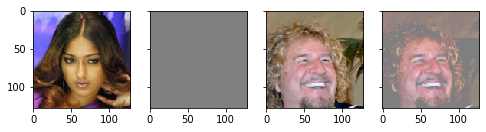

Process ForkPoolWorker-61:
Traceback (most recent call last):
  File "/home/josh/.conda/envs/deep-learning/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/josh/.conda/envs/deep-learning/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/josh/.conda/envs/deep-learning/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/josh/.conda/envs/deep-learning/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
Process ForkPoolWorker-63:
Process ForkPoolWorker-64:
  File "<ipython-input-18-6f0ac1d6149f>", line 48, in swap_faces
    face_landmarks_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/josh/.conda/envs/deep-learning/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/josh/.conda/envs/deep-learning/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Keybo

In [20]:
n_epochs = 8000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Discriminator, S', alpha=0.5)
plt.plot(losses.T[3], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


In [ ]:
# view samples at iteration 4000
view_samples(7000, 'samples_cyclegan')